In [1]:
from fl_spn.partitioner import FederatedDataPartitioner
from trainer import FederatedEiNetTrainer
from utils import load_dataset
from fl_spn.config import SupervisedFLConfig

SupervisedFLConfig.epochs

100

## Start the Experiment

In [2]:
data = load_dataset(name="adult")

partitioner = FederatedDataPartitioner(
    X=data["X_train"],
    y=data["y_train"],
    feature_names=data["X_processed"].columns.tolist(),
    numeric_features=data["numeric_features"],
    categorical_features=data["categorical_features"],
)

In [3]:
print("\n" + "=" * 60)
print("🔵 Test 1: Horizontal Partitioning")
print("=" * 60)

horizontal_partition = partitioner.horizontal_partition(
    num_clients=SupervisedFLConfig.num_clients,
    random_state=SupervisedFLConfig.random_seed,
)

horizontal_trainer = FederatedEiNetTrainer(horizontal_partition)

horizontal_results = horizontal_trainer.train_federated_learning(
    data["X_processed"], epochs=SupervisedFLConfig.epochs, verbose=True
)
horizontal_eval = horizontal_trainer.evaluate_on_test(
        data["X_test"], data["y_test"], data["X_processed"].columns.tolist()
    )


🔵 Test 1: Horizontal Partitioning


Initializing PiecewiseLinear Leaf Layer: 100%|██████████| 3/3 [00:00<00:00, 11.71it/s]
/Users/M279402/PycharmProjects/fl_spn/.venv/lib/python3.10/site-packages/simple_einet/layers/distributions/piecewise_linear.py:263: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BucketizationUtils.h:34.)
  indices = torch.searchsorted(xp, x, right=False)
Initializing PiecewiseLinear Leaf Layer: 100%|██████████| 3/3 [00:00<00:00,  9.57it/s]


In [4]:
print("\n" + "="*60)
print("🟢 Test 2: Vertical Partitioning")
print("="*60)

vertical_partition = partitioner.vertical_partition(
    num_clients=SupervisedFLConfig.num_clients, 
    random_state=SupervisedFLConfig.random_seed)

vertical_trainer = FederatedEiNetTrainer(vertical_partition)

vertical_results = vertical_trainer.train_federated_learning(
    data["X_processed"], epochs=SupervisedFLConfig.epochs, verbose=True
)

# 在測試集上評估
vertical_eval = vertical_trainer.evaluate_on_test(
    data["X_test"], data["y_test"], data["X_processed"].columns.tolist()
)


🟢 Test 2: Vertical Partitioning


Initializing PiecewiseLinear Leaf Layer: 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]


In [5]:
print("\n" + "=" * 60)
print("🟡 Test 3: Hybrid Partitioning")
print("=" * 60)

hybrid_partition = partitioner.hybrid_partition(
    num_clients=SupervisedFLConfig.num_clients,
    sample_overlap_ratio=SupervisedFLConfig.sample_overlap_ratio,
    feature_overlap_ratio=SupervisedFLConfig.feature_overlap_ratio,
    random_state=SupervisedFLConfig.random_seed,
)
hybrid_trainer = FederatedEiNetTrainer(hybrid_partition)
hybrid_results = hybrid_trainer.train_federated_learning(
    data["X_processed"], epochs=SupervisedFLConfig.epochs, verbose=True
)
hybrid_eval = hybrid_trainer.evaluate_on_test(
        data["X_test"], data["y_test"], data["X_processed"].columns.tolist()
    )


🟡 Test 3: Hybrid Partitioning


Initializing PiecewiseLinear Leaf Layer: 100%|██████████| 3/3 [00:00<00:00, 280.19it/s]


In [6]:
methods = ['Horizontal', 'Vertical', 'Hybrid']

train_acc = [horizontal_results['weighted_accuracy'], 
             vertical_results['weighted_accuracy'], 
             hybrid_results['weighted_accuracy']]

train_f1 = [horizontal_results['weighted_f1'], 
          vertical_results['weighted_f1'], 
          hybrid_results['weighted_f1']]

train_time = [horizontal_results['total_training_time'], 
              vertical_results['total_training_time'], 
              hybrid_results['total_training_time']]

clients = [horizontal_results['num_clients'], 
           vertical_results['num_clients'], 
           hybrid_results['num_clients']]

samples = [horizontal_results['total_samples'], 
           vertical_results['total_samples'], 
           hybrid_results['total_samples']]

test_acc = [hybrid_eval['test_accuracy'],
            vertical_eval['test_accuracy'],
            hybrid_eval['test_accuracy']]

test_f1 = [hybrid_eval['test_f1'],
            vertical_eval['test_f1'],
            hybrid_eval['test_f1']]

ensemble_test_acc = [hybrid_eval['ensemble_accuracy']*100,
            vertical_eval['ensemble_accuracy']*100,
            hybrid_eval['ensemble_accuracy']*100]

ensemble_test_f1 = [hybrid_eval['ensemble_f1']*100,
            vertical_eval['ensemble_f1']*100,
            hybrid_eval['ensemble_f1']*100]

colors = ['#F3AA60', '#EF6262', '#468897']

## Plot the results

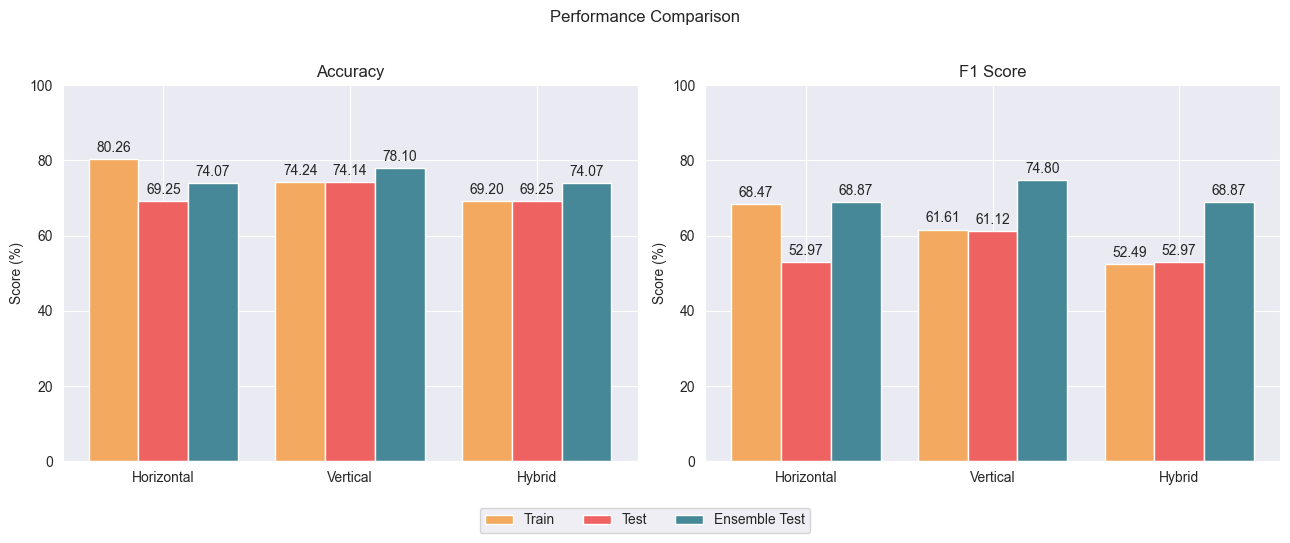

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


bar_labels = ['Train', 'Test', 'Ensemble Test']
bar_groups = 3

x = np.arange(len(methods))          # x: shape=(3,)
width = 0.8 / 3
offsets = [-width, 0, width]

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Performance Comparison')

# --- Left plot: Accuracy ---
ax = axs[0]
rects1 = ax.bar(x + offsets[0], train_acc, width, label=bar_labels[0], color=colors[0])
rects2 = ax.bar(x + offsets[1], test_acc, width, label=bar_labels[1], color=colors[1])
rects3 = ax.bar(x + offsets[2], ensemble_test_acc, width, label=bar_labels[2], color=colors[2])
ax.set_title('Accuracy')
ax.set_ylabel('Score (%)')
ax.set_ylim(0, 100)
ax.set_xticks(x, methods)

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

# --- Right plot: F1 score ---
ax = axs[1]
rects1 = ax.bar(x + offsets[0], train_f1, width, label=bar_labels[0], color=colors[0])
rects2 = ax.bar(x + offsets[1], test_f1, width, label=bar_labels[1], color=colors[1])
rects3 = ax.bar(x + offsets[2], ensemble_test_f1, width, label=bar_labels[2], color=colors[2])

ax.set_title('F1 Score')
ax.set_ylabel('Score (%)')
ax.set_ylim(0, 100)
ax.set_xticks(x, methods)

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

handles = [rects1, rects2, rects3]  # Or: [axs[0].containers[0], axs[0].containers[1], axs[0].containers[2]]
labels = bar_labels

fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.08))
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


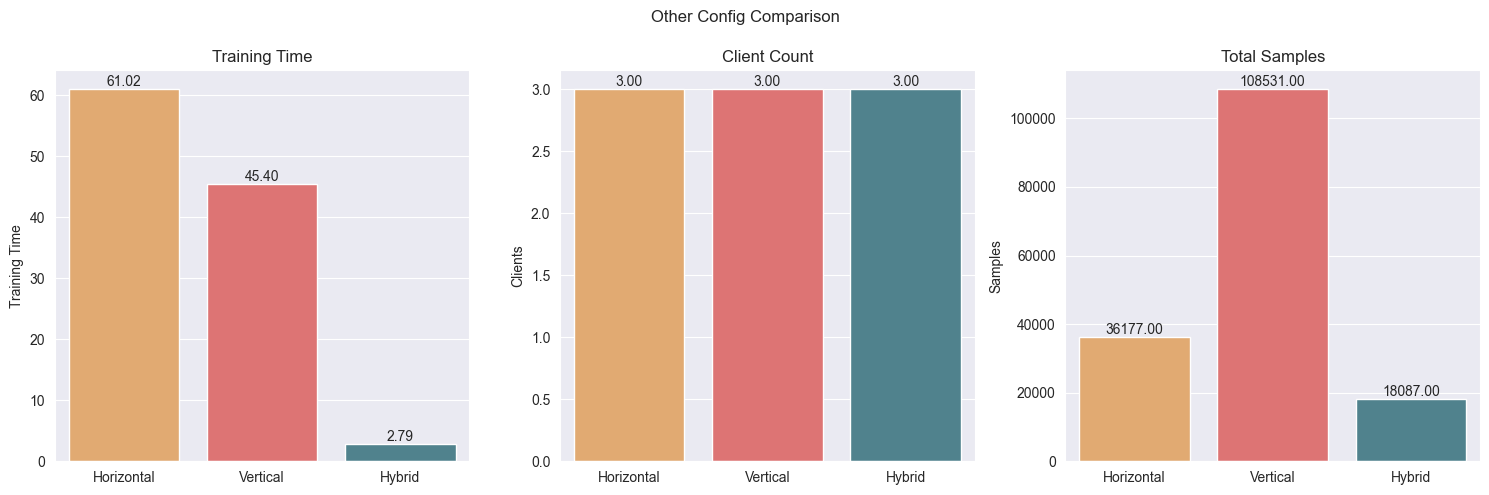

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Other Config Comparison')

titles = ['Training Time', 'Client Count', 'Total Samples']
ydata = [train_time, clients, samples]
ylabs = ['Training Time', 'Clients', 'Samples']

for idx in range(3):
    sns.barplot(
        x=methods, y=ydata[idx], ax=axs[idx], hue=methods,
        palette=colors, errorbar=None, legend=False
    )
    axs[idx].set_title(titles[idx])
    axs[idx].set_xlabel("")
    axs[idx].set_ylabel(ylabs[idx])
    # 若要label在頂端
    for i, val in enumerate(ydata[idx]):
        axs[idx].text(i, val, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()